In [1]:
import sys
sys.path.append('../../common')
import utils
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline
import numpy as np
import pandas
import json
import random
from PIL import Image, ImageDraw
import cPickle as pkl
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
from preprocessing import preprocessing_factory
slim = tf.contrib.slim
import gp_model

In [2]:
utils.set_gpu(1)
num_classes = 340
image_size = 128

images = tf.placeholder(shape=[None, image_size, image_size, 1], dtype=tf.uint8)

image_prep_fn = preprocessing_factory.get_preprocessing('inception_v1', is_training=False)
images_preped = image_prep_fn(images, None, None)

pre_pool, net = gp_model.build_net(images_preped, num_classes, False)

class_probs = tf.nn.softmax(net)

saver = tf.train.Saver(tf.global_variables())
sess = tf.Session()
saver.restore(sess, './log/20190117/140707/model-99001')

cls_id_map = pkl.load(file('../../common/class_id_map.pkl', 'rb'))
id_cls_map = {}
for k in cls_id_map:
    id_cls_map[cls_id_map[k]] = k

inception_prep no aug
INFO:tensorflow:Restoring parameters from ./log/20190117/140707/model-99001


In [3]:
w = sess.run(tf.trainable_variables()[-2])

In [4]:
im_for_resize = tf.placeholder(shape=[1,8,8,1], dtype=tf.float32)

resized = tf.image.resize_bilinear(im_for_resize, [image_size, image_size])

def resize_fn(im_in):
    return sess.run(resized, {im_for_resize: im_in})

12


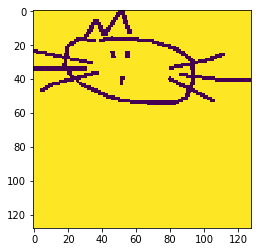

In [5]:
cls = 'cat'
_tmp = pandas.read_csv('../../../data_all/%s.csv'%cls)
n = len(_tmp)
strokes = json.loads(_tmp.iloc[random.randint(0,n-1),1])
print len(strokes)

image = Image.new("P", (256,256), color=255)
image_draw = ImageDraw.Draw(image)
for stroke in strokes:
    for i in range(len(stroke[0])-1):
        image_draw.line([stroke[0][i], 
                         stroke[1][i],
                         stroke[0][i+1], 
                         stroke[1][i+1]],
                        fill=0, width=5)
image = image.resize((128,128))
plt.imshow(np.asarray(image))
#imshow(np.asarray(image), )

(1, 8, 8, 256) (256, 340)


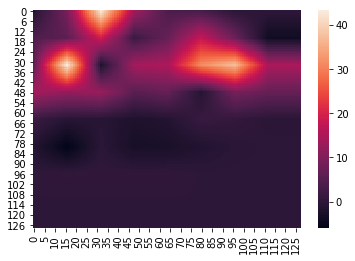

In [6]:
pp = sess.run(pre_pool, {images: np.asarray(image).reshape(1,128,128,1)})
print pp.shape, w.shape
ww = w[:,cls_id_map[cls]]
cam = (pp[0] * ww[None, None,:]).sum(axis=2)
r_cam = resize_fn(cam.reshape([1,8,8,1])).squeeze()
sns.heatmap(r_cam)

In [7]:
"""
For cat, the whiskers and ears contribute to CNN's decision.
"""

"\nFor cat, the whiskers and ears contribute to CNN's decision.\n"